In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

/Users/jteruya/.pyenv/versions/3.8.0/lib/python3.8/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Matlab Plot Settings

In [2]:
# Display Plot within Jupyter Notebook
%matplotlib inline
# Default Plot Size
plt.rcParams['figure.figsize'] = [10, 10]

## Index Data

In [3]:
# Helper Function
def download_data(ticker, start, end):
    return yf.download(ticker, start, end)

# Start and End Dates for Ticker Data
start_date = "2018-01-01"
end_date = "2021-01-05"
# List of Indices to Retrieve Data
indices = ["^VIX", "^GSPC", "^DJI"]
# List of lists
indices_data = [download_data(index, start_date, end_date) for index in indices]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Percent Movement Per Index
Calculate the % change for each day

In [4]:
# Previous Closing
def previous_close(df):
    df['Previous Close'] = df['Close'].shift(1)
    return df

# Percent Movement Helper Function
def market_movement(row):
    return (row['Close'] - row['Previous Close'])/row['Previous Close']

# Get Previous Close to Account for Futures
indices_data_prev = [previous_close(df) for df in indices_data]

# Apply helper function to all index dataframes
percent_movement = [index.apply(market_movement, axis=1) for index in indices_data_prev]

## Visualize Percent Market Per Day

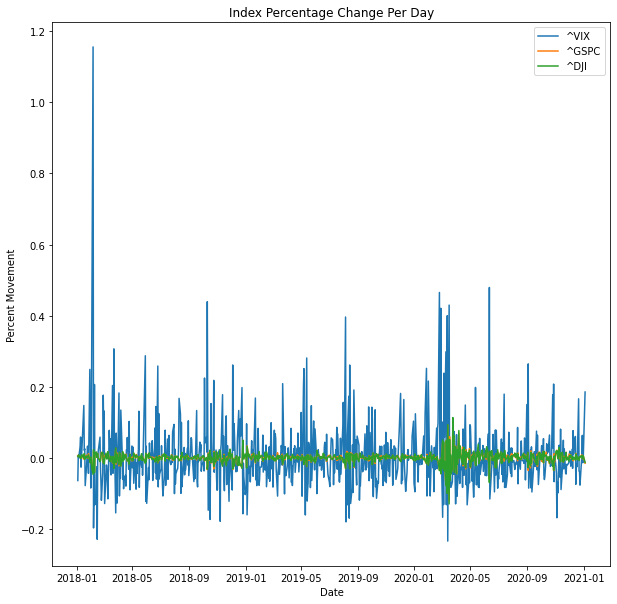

In [5]:
for x in range(len(indices)):
    plt.plot(percent_movement[x], label=indices[x])
plt.xlabel('Date')
plt.ylabel('Percent Movement')
plt.title('Index Percentage Change Per Day')
plt.legend()
plt.show()

## Create Daily Dataframe for Correlation Calculations

In [15]:
# Inital Correlation Dataframe
all_indices_df = pd.concat(percent_movement, axis=1)
all_indices_df.columns = [index[1:] + " Percent Movement" for index in indices]
original_columns = all_indices_df.columns
all_indices_df['Day'] = all_indices_df.index

# Add Timeshifts (by Day)
max_shift = 4
for shift in range(1, max_shift):
    for column in original_columns:
        all_indices_df[column + " + " + str(shift) + " Day Shift"] = all_indices_df[column].shift(-shift)

# Direction Change
all_indices_df['GSPC Same Direction'] = (all_indices_df['GSPC Percent Movement'].shift(1) > 0)^(all_indices_df['GSPC Percent Movement'] < 0)
all_indices_df['VIX Same Direction'] = (all_indices_df['VIX Percent Movement'].shift(1) > 0)^(all_indices_df['VIX Percent Movement'] < 0)
        
# Directional Streak ID
all_indices_df['GSPC Streak'] = 0
all_indices_df['VIX Streak'] = 0

all_indices_df['GSPC Streak'] = all_indices_df.apply(lambda x: 1 if not(x['GSPC Same Direction']) else x['GSPC Streak'], axis=1).cumsum()
all_indices_df['VIX Streak'] = all_indices_df.apply(lambda x: 1 if not(x['VIX Same Direction']) else x['VIX Streak'], axis=1).cumsum()

# Count the consecutive days of a particular streak
all_indices_df['GSPC Streak Consecutive Days'] = all_indices_df.groupby("GSPC Streak")['Day'].rank("dense", ascending=True)
all_indices_df['VIX Streak Consecutive Days'] = all_indices_df.groupby("VIX Streak")['Day'].rank("dense", ascending=True)

# Dependent Variable
all_indices_df['VIX Same Direction Next Day'] = all_indices_df['VIX Same Direction'].shift(-1)

# Correlations on Columns
all_indices_df.tail(10)

,VIX Percent Movement,GSPC Percent Movement,DJI Percent Movement,Day,VIX Percent Movement + 1 Day Shift,GSPC Percent Movement + 1 Day Shift,DJI Percent Movement + 1 Day Shift,VIX Percent Movement + 2 Day Shift,GSPC Percent Movement + 2 Day Shift,DJI Percent Movement + 2 Day Shift,VIX Percent Movement + 3 Day Shift,GSPC Percent Movement + 3 Day Shift,DJI Percent Movement + 3 Day Shift,GSPC Same Direction,VIX Same Direction,GSPC Streak,VIX Streak,GSPC Streak Consecutive Days,VIX Streak Consecutive Days,VIX Same Direction Next Day
Date,,,,,,,,,,,,,,,,,,,,
2020-12-18,-0.016416,-0.003511,-0.004102,2020-12-18,0.166435,-0.003906,0.001239,-0.036963,-0.002073,-0.006650,-0.037969,0.000746,0.003809,False,True,389,390,1.0,4.0,False
2020-12-21,0.166435,-0.003906,0.001239,2020-12-21,-0.036963,-0.002073,-0.006650,-0.037969,0.000746,0.003809,-0.076362,0.003537,0.002325,True,False,389,391,2.0,1.0,False
2020-12-22,-0.036963,-0.002073,-0.006650,2020-12-22,-0.037969,0.000746,0.003809,-0.076362,0.003537,0.002325,0.007896,0.008723,0.006758,True,False,389,392,3.0,1.0,True
2020-12-23,-0.037969,0.000746,0.003809,2020-12-23,-0.076362,0.003537,0.002325,0.007896,0.008723,0.006758,0.063594,-0.002227,-0.002246,False,True,390,392,1.0,2.0,True
2020-12-24,-0.076362,0.003537,0.002325,2020-12-24,0.007896,0.008723,0.006758,0.063594,-0.002227,-0.002246,-0.013432,0.001342,0.002436,True,True,390,392,2.0,3.0,False
2020-12-28,0.007896,0.008723,0.006758,2020-12-28,0.063594,-0.002227,-0.002246,-0.013432,0.001342,0.002436,-0.000878,0.006439,0.006476,True,False,390,393,3.0,1.0,True
2020-12-29,0.063594,-0.002227,-0.002246,2020-12-29,-0.013432,0.001342,0.002436,-0.000878,0.006439,0.006476,0.185494,-0.014755,-0.012500,False,True,391,393,1.0,2.0,False
2020-12-30,-0.013432,0.001342,0.002436,2020-12-30,-0.000878,0.006439,0.006476,0.185494,-0.014755,-0.012500,NaN,NaN,NaN,False,False,392,394,1.0,1.0,True
2020-12-31,-0.000878,0.006439,0.006476,2020-12-31,0.185494,-0.014755,-0.012500,NaN,NaN,NaN,NaN,NaN,NaN,True,True,392,394,2.0,2.0,False


## VIX Directional Model

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

# Categorical Label Encoder for Dependent Variable
le = preprocessing.LabelEncoder()

#X = all_indices_df[['GSPC Streak Consecutive Days', 'VIX Streak Consecutive Days']][:-1]
X = all_indices_df[['GSPC Streak Consecutive Days', 'VIX Streak Consecutive Days', 'VIX Percent Movement', 'GSPC Percent Movement', 'DJI Percent Movement']][1:-1]
#X = all_indices_df[['VIX Percent Movement']][:-1]
y = all_indices_df['VIX Same Direction Next Day'][1:-1]

# Encode Categorical Dependent Variable
le.fit(y)
y = le.transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Train the Model
clf = LogisticRegression(random_state=0).fit(X_train, y_train)

clf.predict(X_test)
clf.predict_proba(X_test)

# Score the Model
clf.score(X_test, y_test)

0.5761589403973509

## Prediction

In [19]:
# Prediction
clf.predict([all_indices_df.loc['2020-12-31'][['VIX Percent Movement', 'GSPC Percent Movement', 'DJI Percent Movement', 'GSPC Streak Consecutive Days', 'VIX Streak Consecutive Days']]])


array([1])

## Calculate Correlations

In [9]:
# Correlations on Columns
all_indices_df.corr(method ='pearson')

,VIX Percent Movement,GSPC Percent Movement,DJI Percent Movement,VIX Percent Movement + 1 Day Shift,GSPC Percent Movement + 1 Day Shift,DJI Percent Movement + 1 Day Shift,VIX Percent Movement + 2 Day Shift,GSPC Percent Movement + 2 Day Shift,DJI Percent Movement + 2 Day Shift,VIX Percent Movement + 3 Day Shift,GSPC Percent Movement + 3 Day Shift,DJI Percent Movement + 3 Day Shift,GSPC Same Direction,VIX Same Direction,GSPC Streak,VIX Streak,GSPC Streak Consecutive Days,VIX Streak Consecutive Days
VIX Percent Movement,1.000000,-0.686874,-0.659659,-0.071789,0.103930,0.098527,0.002998,-0.106774,-0.111177,0.043003,-0.078735,-0.079910,0.075086,-0.038503,-0.018409,-0.016262,0.100876,-0.058817
GSPC Percent Movement,-0.686874,1.000000,0.978329,0.134908,-0.264756,-0.253680,-0.038756,0.188469,0.189829,-0.027614,-0.008016,-0.019025,-0.029207,-0.013885,0.026642,0.025490,-0.038357,0.010968
DJI Percent Movement,-0.659659,0.978329,1.000000,0.130646,-0.250577,-0.237664,-0.037419,0.192140,0.191261,-0.017971,-0.011783,-0.026631,-0.023937,-0.009880,0.020308,0.018949,-0.030641,0.014976
VIX Percent Movement + 1 Day Shift,-0.071789,0.134908,0.130646,1.000000,-0.686874,-0.659659,-0.071789,0.103930,0.098527,0.002998,-0.106774,-0.111177,0.046432,-0.019610,-0.018075,-0.016428,0.050339,0.006229
GSPC Percent Movement + 1 Day Shift,0.103930,-0.264756,-0.250577,-0.686874,1.000000,0.978329,0.134908,-0.264756,-0.253680,-0.038756,0.188469,0.189829,0.018436,0.043682,0.026517,0.025435,0.001067,0.013791
DJI Percent Movement + 1 Day Shift,0.098527,-0.253680,-0.237664,-0.659659,0.978329,1.000000,0.130646,-0.250577,-0.237664,-0.037419,0.192140,0.191261,0.013723,0.036035,0.020205,0.018910,-0.002299,0.014942
VIX Percent Movement + 2 Day Shift,0.002998,-0.038756,-0.037419,-0.071789,0.134908,0.130646,1.000000,-0.686800,-0.659684,-0.071793,0.104190,0.098912,0.021085,0.096792,-0.019512,-0.018090,0.017478,0.063647
GSPC Percent Movement + 2 Day Shift,-0.106774,0.188469,0.192140,0.103930,-0.264756,-0.250577,-0.686800,1.000000,0.978345,0.134912,-0.264920,-0.253924,-0.061108,-0.074090,0.027571,0.026548,-0.047597,-0.044222
DJI Percent Movement + 2 Day Shift,-0.111177,0.189829,0.191261,0.098527,-0.253680,-0.237664,-0.659684,0.978345,1.000000,0.130644,-0.250668,-0.237807,-0.060204,-0.073609,0.020839,0.019607,-0.043518,-0.041092
VIX Percent Movement + 3 Day Shift,0.043003,-0.027614,-0.017971,0.002998,-0.038756,-0.037419,-0.071793,0.134912,0.130644,1.000000,-0.686832,-0.659754,-0.024107,-0.032948,-0.019412,-0.017665,-0.043520,-0.025203


## Monthly Correlations

In [10]:
all_indices_df = pd.concat(percent_movement, axis=1)
all_indices_df.columns = [index[1:] + " Percent Movement" for index in indices]
all_indices_df['Month'] = all_indices_df.index.year * 100 + all_indices_df.index.month

months = all_indices_df['Month'].unique().tolist()

max_shift = 4
for shift in range(1, max_shift):
    for column in original_columns:
        all_indices_df[column + " + " + str(shift) + " Day Shift"] = all_indices_df[column].shift(-shift)

all_indices_df = all_indices_df.groupby(['Month']).corr(method ='pearson')

vix = []
dji = []
vix_1 = []
dji_1 = []
vix_2 = []
dji_2 = []
vix_3 = []
dji_3 = []

for month in months:
    monthly_indices_df = all_indices_df.loc[month, "GSPC Percent Movement"]
    vix.append(monthly_indices_df['VIX Percent Movement'])
    dji.append(monthly_indices_df['DJI Percent Movement'])
    vix_1.append(monthly_indices_df['VIX Percent Movement + 1 Day Shift'])
    dji_1.append(monthly_indices_df['DJI Percent Movement + 1 Day Shift'])
    vix_2.append(monthly_indices_df['VIX Percent Movement + 2 Day Shift'])
    dji_2.append(monthly_indices_df['DJI Percent Movement + 2 Day Shift'])
    vix_3.append(monthly_indices_df['VIX Percent Movement + 3 Day Shift'])
    dji_3.append(monthly_indices_df['DJI Percent Movement + 3 Day Shift'])
    
monthly_data = {'MONTH': [datetime.strptime(str(month), '%Y%m') for month in months], 'VIX': vix, 'DOW': dji, 'VIX+1': vix_1, 'DJI+1': dji_1, 'VIX+2': vix_2, 'DJI+2': dji_2, 'VIX+3': vix_3, 'DJI+3': dji_3}
monthly_df = pd.DataFrame(data = monthly_data).set_index('MONTH')
#monthly_df.to_csv('sp500_correlation_raw.csv')
monthly_df


,VIX,DOW,VIX+1,DJI+1,VIX+2,DJI+2,VIX+3,DJI+3
MONTH,,,,,,,,
2018-01-01,-0.584461,0.908449,0.537106,-0.091086,0.126839,-0.053346,-0.257324,0.398595
2018-02-01,-0.812976,0.987910,-0.163447,0.096323,0.199126,-0.356527,-0.158202,0.252710
2018-03-01,-0.871461,0.966292,0.291003,-0.234796,0.173830,-0.202881,-0.462713,0.371453
2018-04-01,-0.911940,0.978210,0.061317,-0.201744,0.228598,-0.242843,0.156660,-0.124479
2018-05-01,-0.793973,0.950399,0.224833,-0.316489,-0.153256,0.149362,0.169517,0.022289
2018-06-01,-0.926272,0.896844,0.273717,0.030988,-0.496409,0.468370,0.215291,0.010169
2018-07-01,-0.849138,0.871366,-0.030024,0.171743,0.322803,0.020957,0.113434,-0.180847
2018-08-01,-0.818560,0.884968,0.099037,-0.061710,-0.121774,0.120792,0.009906,-0.191299
2018-09-01,-0.765297,0.826566,-0.191978,0.223079,0.434898,0.013413,0.063894,-0.162571


## Plot Monthly Correlations over Time for SP500

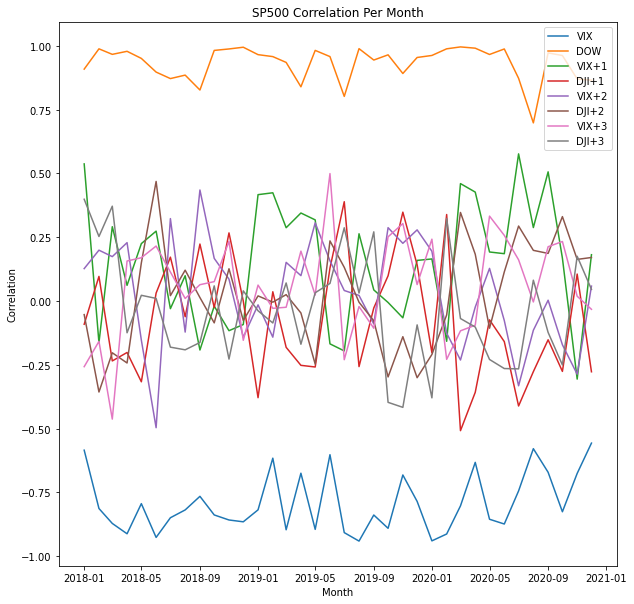

In [11]:
for x in range(len(monthly_df.columns)):
    plt.plot(monthly_df[monthly_df.columns[x]], label=monthly_df.columns[x])
plt.xlabel('Month')
plt.ylabel('Correlation')
plt.title('SP500 Correlation Per Month')
plt.legend()
plt.show()